In [ ]:
from google.colab import drive

# 1. Google Drive 마운트
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 2. 파일 경로 설정 (사용자 지정 경로)
data_root = '/content/drive/MyDrive/Colab Notebooks/datathon/주력_비주력상품 데이터/비주력상품'
# file_path = f'{data_root}/2019-Nov.csv'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import os

In [ ]:
sns.set()

# 그래프 기본 설정
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False
import matplotlib as mpl
import matplotlib.font_manager as fm

# 폰트 파일 경로 지정
font_path = '/content/drive/MyDrive/font/NanumGothic.ttf'

# 폰트 등록 및 matplotlib 설정
font_name = fm.FontProperties(fname=font_path).get_name()
fm.fontManager.addfont(font_path)
mpl.rc('font', family=font_name)

In [ ]:
# 데이터 불러오기
notop_multi_df = pd.read_parquet(f'{data_root}/noTop3_multi_buyers_all_events.parquet')
notop_one_df = pd.read_parquet(f'{data_root}/noTop3_one_time_buyers_all_events.parquet')


1회 구매 퍼널 분석

In [ ]:
# 비주력 1회 구매 퍼널 분석
# 퍼널 분석 (view-cart-purchase 단계별 유저 수 및 전환율)
# 사용자별 event_type 집계
funnel_counts = notop_one_df.groupby('event_type')['user_id'].nunique().reindex(['view', 'cart', 'purchase'])

# 전환율 계산 (순차적 전환 기준)
view_to_cart = funnel_counts['cart'] / funnel_counts['view'] if funnel_counts['view'] else 0
cart_to_purchase = funnel_counts['purchase'] / funnel_counts['cart'] if funnel_counts['cart'] else 0
view_to_purchase = funnel_counts['purchase'] / funnel_counts['view'] if funnel_counts['view'] else 0

print(funnel_counts)
print(f"view_to_cart: {view_to_cart}")
print(f"cart_to_purchase: {cart_to_purchase}")
print(f"view_to_purchase: {view_to_purchase}")

event_type
view        295577
cart        275220
purchase    296618
Name: user_id, dtype: int64
view_to_cart: 0.931127929439706
cart_to_purchase: 1.077748710122811
view_to_purchase: 1.0035219249129668


2회 이상 구매 퍼널 분석

In [ ]:
# 비주력 2회 이상 구매 퍼널 분석
# 퍼널 분석 (view-cart-purchase 단계별 유저 수 및 전환율)
# 사용자별 event_type 집계
funnel_counts = notop_multi_df.groupby('event_type')['user_id'].nunique().reindex(['view', 'cart', 'purchase'])

# 전환율 계산 (순차적 전환 기준)
view_to_cart = funnel_counts['cart'] / funnel_counts['view'] if funnel_counts['view'] else 0
cart_to_purchase = funnel_counts['purchase'] / funnel_counts['cart'] if funnel_counts['cart'] else 0
view_to_purchase = funnel_counts['purchase'] / funnel_counts['view'] if funnel_counts['view'] else 0

print(funnel_counts)
print(f"view_to_cart: {view_to_cart}")
print(f"cart_to_purchase: {cart_to_purchase}")
print(f"view_to_purchase: {view_to_purchase}")

event_type
view        205370
cart        200896
purchase    205500
Name: user_id, dtype: int64
view_to_cart: 0.9782149291522618
cart_to_purchase: 1.0229173303599872
view_to_purchase: 1.0006330038467157


평균 cart 보유 시간 비교(수치 확인)

In [ ]:
df = notop_one_df  # 1회 구매자용 전체 데이터

# 1. event_datetime 생성 (vectorized 방식)
df['event_datetime'] = pd.to_datetime(df['event_date']) + pd.to_timedelta(df['event_hour'], unit='h')

# 2. cart & purchase 이벤트 필터링
df_cart = df[df['event_type'] == 'cart']
df_purchase = df[df['event_type'] == 'purchase']

# 3. 세션별 가장 빠른 cart/purchase 시간 추출
cart_times = df_cart.groupby('user_session')['event_datetime'].min().to_frame(name='cart_time')
purchase_times = df_purchase.groupby('user_session')['event_datetime'].min().to_frame(name='purchase_time')

# 4. 공통 세션만 남기고 merge
merged = pd.merge(cart_times, purchase_times, left_index=True, right_index=True)

# 5. 시간차 계산
cart_hold_time = (merged['purchase_time'] - merged['cart_time']).dt.total_seconds() / 3600

# 6. 음수 제거 (올바른 순서만 필터링)
cart_hold_time = cart_hold_time[cart_hold_time >= 0]

# 7. 결과 출력
print(f"[1회 구매자] 평균 Cart 보유 시간 (시간): {cart_hold_time.mean():.2f}")

[1회 구매자] 평균 Cart 보유 시간 (시간): 1.42


In [ ]:
cart_hold_time_one_time = cart_hold_time #1회 구매자

In [ ]:
df = notop_multi_df  # 다회 구매자용 전체 데이터

# 1. event_datetime 생성 (vectorized 방식)
df['event_datetime'] = pd.to_datetime(df['event_date']) + pd.to_timedelta(df['event_hour'], unit='h')

# 2. cart & purchase 이벤트 필터링
df_cart = df[df['event_type'] == 'cart']
df_purchase = df[df['event_type'] == 'purchase']

# 3. 세션별 가장 빠른 cart/purchase 시간 추출
cart_times = df_cart.groupby('user_session')['event_datetime'].min().to_frame(name='cart_time')
purchase_times = df_purchase.groupby('user_session')['event_datetime'].min().to_frame(name='purchase_time')

# 4. 공통 세션만 남기고 merge
merged = pd.merge(cart_times, purchase_times, left_index=True, right_index=True)

# 5. 시간차 계산
cart_hold_time = (merged['purchase_time'] - merged['cart_time']).dt.total_seconds() / 3600

# 6. 음수 제거 (올바른 순서만 필터링)
cart_hold_time = cart_hold_time[cart_hold_time >= 0]

# 7. 결과 출력
print(f"[다회 구매자] 평균 Cart 보유 시간 (시간): {cart_hold_time.mean():.2f}")

[다회 구매자] 평균 Cart 보유 시간 (시간): 0.80


In [ ]:
cart_hold_time_multi = cart_hold_time # 다회 구매자

평균 cart 보유 시간 비교(막대 그래프)

In [ ]:
# 구간 정의
bins = [0, 1, 3, 24, 48, 9999]
labels = ['<1시간', '1~3시간', '3~24시간', '24~48시간', '48시간 이상']

# 카테고리 라벨링
one_time_cut = pd.cut(cart_hold_time_one_time, bins=bins, labels=labels, right=False)
multi_cut = pd.cut(cart_hold_time_multi, bins=bins, labels=labels, right=False)

# 비율 계산
one_time_ratio = one_time_cut.value_counts(normalize=True).sort_index()
multi_ratio = multi_cut.value_counts(normalize=True).sort_index()

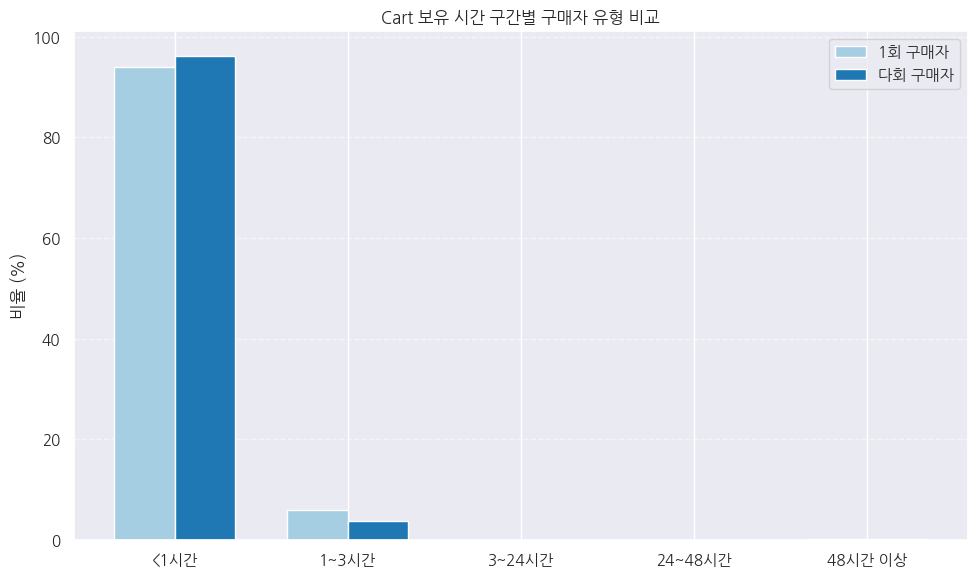

In [ ]:
# 그룹형 막대그래프
import numpy as np

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - width/2, one_time_ratio.values * 100, width, label='1회 구매자', color='#a6cee3')
plt.bar(x + width/2, multi_ratio.values * 100, width, label='다회 구매자', color='#1f78b4')

plt.xticks(x, labels)
plt.ylabel('비율 (%)')
plt.title('Cart 보유 시간 구간별 구매자 유형 비교')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

평균 cart 보유 시간 1시간 이상 비율 확인

In [ ]:
# 1시간 이상 보유한 경우만 필터링
one_time_over1h = cart_hold_time_one_time[cart_hold_time_one_time >= 1]
multi_over1h = cart_hold_time_multi[cart_hold_time_multi >= 1]

In [ ]:
print(f"[1회 구매자] 1시간 이상 보유 비율: {len(one_time_over1h) / len(cart_hold_time_one_time) * 100:.2f}%")
print(f"[다회 구매자] 1시간 이상 보유 비율: {len(multi_over1h) / len(cart_hold_time_multi) * 100:.2f}%")

[1회 구매자] 1시간 이상 보유 비율: 5.98%
[다회 구매자] 1시간 이상 보유 비율: 3.73%


평균 cart 보유 시간 1시간 이상 분포(막대 그래프)

In [ ]:
# 1시간 이상만 다루므로 bins 조정
bins_1hplus = [1, 3, 24, 48, 9999]
labels_1hplus = ['1~3시간', '3~24시간', '24~48시간', '48시간 이상']

# cut
one_time_cut_1hplus = pd.cut(one_time_over1h, bins=bins_1hplus, labels=labels_1hplus, right=False)
multi_cut_1hplus = pd.cut(multi_over1h, bins=bins_1hplus, labels=labels_1hplus, right=False)

# 비율
one_time_ratio_1hplus = one_time_cut_1hplus.value_counts(normalize=True).sort_index()
multi_ratio_1hplus = multi_cut_1hplus.value_counts(normalize=True).sort_index()

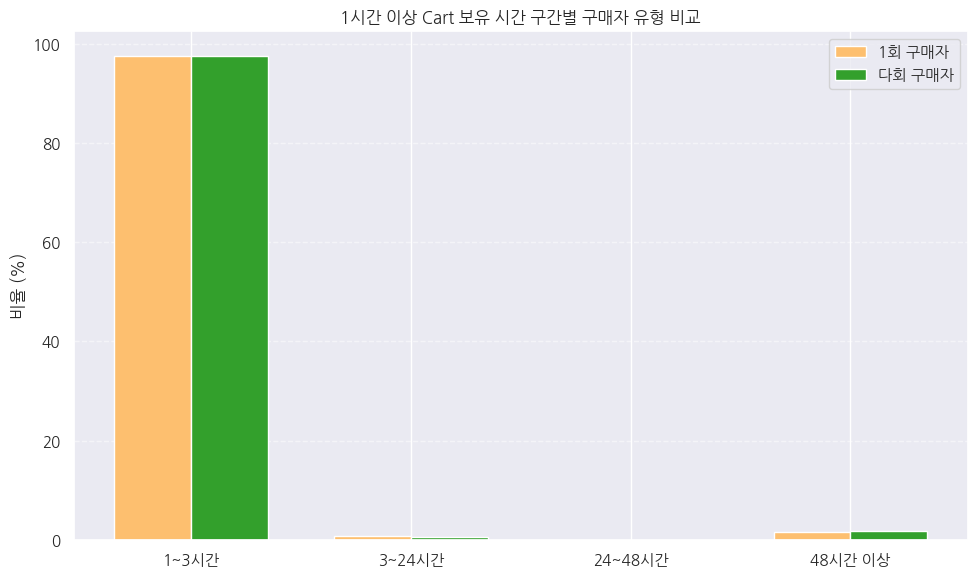

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(len(labels_1hplus))
width = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - width/2, one_time_ratio_1hplus.values * 100, width, label='1회 구매자', color='#fdbf6f')
plt.bar(x + width/2, multi_ratio_1hplus.values * 100, width, label='다회 구매자', color='#33a02c')

plt.xticks(x, labels_1hplus)
plt.ylabel('비율 (%)')
plt.title('1시간 이상 Cart 보유 시간 구간별 구매자 유형 비교')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

비주력 상품 1회 구매자 vs 2회 이상 구매자 비교

| 항목               | **2회 이상 구매자**   | **1회 구매자**      | **차이점**                       |
| ---------------- | --------------- | --------------- | ----------------------------- |
| **평균 세션 수**      | 17.67           | 8.95            | 🔻 8.72개 감소 (약 **49%** ↓)     |
| **평균 이벤트 수**     | 96.83           | 43.86           | 🔻 52.97개 감소 (약 **55%** ↓)    |
| **평균 탐색 카테고리 수** | 3.93            | 2.99            | 🔻 약 **24%** 감소               |
| **평균 브랜드 수**     | 14.09           | 8.13            | 🔻 약 **42%** 감소               |
| **평균 구매 간격 (일)** | **8.71일**       | -               | (1회 구매자는 해당 없음)               |
| **주요 구매 요일**     | Mon > Sun > Tue | Sun > Mon > Tue | 주초(월) 중심 vs 주말(일) 중심 차이       |
| **주요 구매 시간대**    | 14시 > 13시 > 15시 | 14시 > 13시 > 15시 | 유사하지만 다회 구매자는 **이른 시간대**에도 활발 |

- 다회 구매자는 모든 항목에서 2배 이상 활발(탐색 의지 강하고 제품 비교 행동 활발), 첫 구매 전 고민 더 많음(cart 넣었다가 여러 번 view 하는 패턴 보임, 비교 및 추천 기능 강화 필요)
- 반면, 1회 구매자는 단발성 구매 행동 위주
- 구매 간격: 다회 구매자는 평균 1주일 내 재구매 -> 리타겟팅 타이밍이 핵심
- 재방문 유도 포인트: 1회 구매자에게도 브랜드 비교, 다양한 추천 제공이 구매 결정에 긍정적일 수도, 특히 13-15시/주말~월요일 타이밍에 마케팅 집중하면 좋음
- 1회는 주말/오후, 다회는 평일/오전부터 고르게 활발

In [ ]:
# 상위 10개 카테고리 추출 (전체 데이터 기준)
top_10_categories = pd.concat([notop_one_df, notop_multi_df])['category_lvl1'].value_counts().nlargest(10).index.tolist()

def calculate_avg_cart_hold_time_by_category(df, categories):
    """
    주어진 DataFrame에서 특정 카테고리별 평균 Cart 보유 시간을 계산합니다.
    """
    category_avg_hold_times = {}
    for category in categories:
        df_cat = df[df['category_lvl1'] == category].copy()

        if df_cat.empty:
            category_avg_hold_times[category] = 0
            continue

        # 1. event_datetime 생성
        df_cat['event_datetime'] = pd.to_datetime(df_cat['event_date']) + pd.to_timedelta(df_cat['event_hour'], unit='h')

        # 2. cart & purchase 이벤트 필터링
        df_cart = df_cat[df_cat['event_type'] == 'cart']
        df_purchase = df_cat[df_cat['event_type'] == 'purchase']

        if df_cart.empty or df_purchase.empty:
            category_avg_hold_times[category] = 0
            continue

        # 3. 세션별 가장 빠른 cart/purchase 시간 추출
        cart_times = df_cart.groupby('user_session')['event_datetime'].min().to_frame(name='cart_time')
        purchase_times = df_purchase.groupby('user_session')['event_datetime'].min().to_frame(name='purchase_time')

        # 4. 공통 세션만 남기고 merge
        merged = pd.merge(cart_times, purchase_times, left_index=True, right_index=True)

        if merged.empty:
            category_avg_hold_times[category] = 0
            continue

        # 5. 시간차 계산
        cart_hold_time = (merged['purchase_time'] - merged['cart_time']).dt.total_seconds() / 3600

        # 6. 음수 제거 (올바른 순서만 필터링)
        cart_hold_time = cart_hold_time[cart_hold_time >= 0]

        if cart_hold_time.empty:
             category_avg_hold_times[category] = 0
             continue

        # 7. 결과 저장
        category_avg_hold_times[category] = cart_hold_time.mean()

    return category_avg_hold_times

# 1회 구매자 카테고리별 평균 Cart 보유 시간 계산
one_time_category_hold_times = calculate_avg_cart_hold_time_by_category(notop_one_df, top_10_categories)

# 다회 구매자 카테고리별 평균 Cart 보유 시간 계산
multi_category_hold_times = calculate_avg_cart_hold_time_by_category(notop_multi_df, top_10_categories)

# 결과 출력
print("[1회 구매자] 카테고리별 평균 Cart 보유 시간 (시간):")
for category, avg_time in one_time_category_hold_times.items():
    print(f"{category}: {avg_time:.2f}")

print("\n[다회 구매자] 카테고리별 평균 Cart 보유 시간 (시간):")
for category, avg_time in multi_category_hold_times.items():
    print(f"{category}: {avg_time:.2f}")

[1회 구매자] 카테고리별 평균 Cart 보유 시간 (시간):
apparel: 1.10
computers: 1.38
sport: 0.64
furniture: 1.21
kids: 1.62
auto: 0.56
accessories: 0.46
country_yard: 0.07
medicine: 0.06
stationery: 6.11

[다회 구매자] 카테고리별 평균 Cart 보유 시간 (시간):
apparel: 0.61
computers: 0.79
sport: 0.39
furniture: 0.87
kids: 1.18
auto: 0.39
accessories: 0.22
country_yard: 0.06
medicine: 0.03
stationery: 0.79


고객별 view-cart-purchase 퍼널 분석(막대 그래프) - 수정 필요

In [ ]:
# 퍼널 분석 (view-cart-purchase 단계별 유저 수 및 전환율)
# 사용자별 event_type 집계
funnel_counts = top_one_df.groupby('event_type')['user_id'].nunique().reindex(['view', 'cart', 'purchase'])

# 전환율 계산 (순차적 전환 기준)
view_to_cart = funnel_counts['cart'] / funnel_counts['view'] if funnel_counts['view'] else 0
cart_to_purchase = funnel_counts['purchase'] / funnel_counts['cart'] if funnel_counts['cart'] else 0
view_to_purchase = funnel_counts['purchase'] / funnel_counts['view'] if funnel_counts['view'] else 0

print(funnel_counts)
print(f"view_to_cart: {view_to_cart}")
print(f"cart_to_purchase: {cart_to_purchase}")
print(f"view_to_purchase: {view_to_purchase}")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 단계별 정의
stages = ['View', 'Cart', 'Purchase']
x = np.arange(len(stages))

# 전환율 (View 기준 100%)
one_time_rates = [1.0, 0.9283, 1.0039]     # 1회 구매자
multi_rates    = [1.0, 0.9834, 1.0009]     # 다회 구매자

# 막대 너비 설정
width = 0.35

# 시각화
plt.figure(figsize=(10, 6))
bars1 = plt.bar(x - width/2, [r * 100 for r in one_time_rates], width, label='1회 구매자', color='#a6cee3')
bars2 = plt.bar(x + width/2, [r * 100 for r in multi_rates], width, label='다회 구매자', color='#1f78b4')

# 텍스트 라벨링
for i in range(len(stages)):
    plt.text(x[i] - width/2, one_time_rates[i] * 100 + 0.5, f'{one_time_rates[i]*100:.1f}%', ha='center', fontsize=10)
    plt.text(x[i] + width/2, multi_rates[i] * 100 + 0.5, f'{multi_rates[i]*100:.1f}%', ha='center', fontsize=10)

# 그래프 설정
plt.xticks(x, stages)
plt.ylabel('Conversion Rate (%)')
plt.title('전환 퍼널 비교: 1회 구매자 vs 다회 구매자')
plt.ylim(0, 110)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show